## Description

This notebook contains a reproduction of case studies from the article *The Clade Displacement Index: how to detect hotizontal gene transfers in unrooted gene trees* by Michał Aleksander Ciach (Faculty of Mathematics, Informatics and Mechanics, University of Warsaw; m.ciach@mimuw.edu.pl).  

We analyze homologous families of two proteins of a parasitic plant *Striga hermonthica* using the Clade Displacement Index (CDI).  
The first protein is putatively transferred from one of *Striga*'s hosts, while the second protein shows no evidence of horizontal gene transfer (HGT) in its evolutionary history.  
We also use CDI to analyze the stability of topology of the estimated gene trees, in particular the stability of location of the *Striga* clade.  

Before the analysis, run the section *Module imports & function definitions* at the bottom of this notebook.  

## Protein BAJ06366.1; Horizontal gene transfer

This protein was reported to be transferred from *Striga*'s host, *Sorghum bicolor*.  
We have selected several of its homologs found with the BlastP suite and generated their gene tree.  
We have included homologs from *Setaria* species, which are more similar to *BAJ06366.1* than *Sorghum*'s homologs, but were not included in the original study (The *Setaria* species were sequenced after the study was published).  
Our analysis shows that BAJ06366.1 was likely to be transferred from *Setaria*, a close relative of *Sorghum*. 

**Loading the data**

Load the table mapping the Protein Accessions to the TaxIDs of their organisms:

In [18]:
taxid_table = 'Data/BAJ06366.1_taxid_table.tsv'
taxid_table = [l.strip().split() for l in open(taxid_table)]

Create mappings between TaxIDs and Accessions:

In [19]:
taxids = [t for a,t in taxid_table]
tx_to_acc = {t:a for a,t in taxid_table}
acc_to_tx = {a:t for a,t in taxid_table}

Load the species tree $S$:

In [122]:
S = Tree('Data/BAJ06366.1.speciestree')

In [123]:
### Alternatively, to download the species tree from a local copy of the NCBI Taxonomy database
### and save it to Data/BAJ06366.1.speciestree file:

# from ete3 import NCBITaxa
# ncbi = NCBITaxa()
# S = ncbi.get_topology(taxids)
# S.write(outfile='Data/BAJ06366.1.speciestree', format=8, features=['sci_name'])

In [124]:
print(S.get_ascii(attributes=['sci_name']))


                  /-Brachypodium distachyon
          /Pooideae
         |       |        /-Triticum aestivum
         |        \Triticum
   /Poaceae               \-Triticum dicoccoides
  |      |
  |      |                  /-Setaria italica
  |      |           /Setaria
--|       \Panicoideae      \-Setaria viridis
  |                 |
  |                  \-Sorghum bicolor
  |
  |      /-Striga hermonthica
   \Striga
         \-Striga gesnerioides


In [45]:
S.show(tree_style=species_style)

Use $S$ to get a mapping from protein accession to the species scientific name:

In [80]:
tx_to_name = {l.name: l.sci_name for l in S}
acc_to_name = {acc: tx_to_name[acc_to_tx[acc]] for acc in acc_to_tx}

Load the gene tree $G$:

In [52]:
G = Tree('Data/BAJ06366.1.genetree')

Root the gene tree using the midpoint method (a root is required by our algorithms, but its location does not change the results):

In [53]:
G.set_outgroup(G.get_midpoint_outgroup())

Label the leaves of G with their corresponding TaxIDs and scientific names:

In [54]:
for l in G:
    l.accession = l.name
    l.name = acc_to_tx[l.name]
    l.sci_name = S.search_nodes(name=l.name)[0].sci_name

In [55]:
print(G.get_ascii(attributes=['sci_name', 'accession', 'name']))


            /-Triticum dicoccoides, XP_037439433.1, 85692
         /-|
      /-|   \-Triticum aestivum, KAF7063565.1, 4565
     |  |
   /-|   \-Triticum dicoccoides, XP_037439440.1, 85692
  |  |
  |   \-Brachypodium distachyon, XP_003568978.1, 15368
  |
  |      /-Sorghum bicolor, XP_021315060.1, 4558
--|   /-|
  |  |   \-Sorghum bicolor, KAG0549370.1, 4558
  |  |
  |  |      /-Setaria italica, XP_004961077.1, 4555
  |  |     |
   \-|     |         /-Setaria italica, XP_004956429.1, 4555
     |   /-|      /-|
     |  |  |     |  |   /-Setaria viridis, XP_034578836.1, 4556
     |  |  |   /-|   \-|
     |  |  |  |  |      \-Setaria viridis, TKW32332.1, 4556
     |  |   \-|  |
      \-|     |   \-Setaria viridis, TKW32329.1, 4556
        |     |
        |      \-Setaria italica, RCV11063.1, 4555
        |
        |   /-Striga hermonthica, BAJ06366.1, 68872
         \-|
            \-Striga gesnerioides, BAJ09025.1, 46029


**Detecting HGT**

We can see that the *Striga* clade branches with *Setaria* instead of the whole *Setaria*/*Sorghum* clade, indicating a horizontal gene transfer.  
Clade Displacement Index confirms this unexpected branching.

In [130]:
target_taxids = {'68872', '46029'}
gs = get_multisplit_from_target(G, target_taxids)
ss = get_multisplit_from_target(S, target_taxids)
CDI = multisplit_distance(gs, ss)
print('CDI of the Striga clade between the gene and the species trees is equal to', CDI)

CDI of the Striga clade between the gene and the species trees is equal to 0.0


Non-zero CDI of the striga clade indicates a displacement of this clade, which suggests that the clade's ancestor acquired the gene through a horizontal gene transfer.  

**HGT support**

We can now check if this unexpected location of *Setaria* clade is supported by the bootstrap replicates.  
We will reload the gene tree so that its leaves are labeled with protein accessions instead of TaxIDs. 

In [71]:
G = Tree('Data/BAJ06366.1.genetree')
G.set_outgroup(G.get_midpoint_outgroup())

Now, we will load the bootstrapped trees (with leaves labeled by protein accessions).  

In [72]:
with open('Data/BAJ06366.1.boottrees') as h:
    boottrees = [Tree(l) for l in h]
for T in boottrees:
    T.set_outgroup(T.get_midpoint_outgroup())
print(len(boottrees), 'bootstrapped trees loaded')

100 bootstrapped trees loaded


We will compute the CDI of the striga clade between the maximum likelihood tree and each of the bootstrapped trees. 

In [65]:
target_accessions = {'BAJ06366.1', 'BAJ09025.1'}

In [73]:
striga_CDIs = []
for T in boottrees:
    gs = get_multisplit_from_target(G, target_accessions)
    ts = get_multisplit_from_target(T, target_accessions)
    CDI = multisplit_distance(gs, ts) 
    striga_CDIs.append(CDI)

Plot the distribution of CDIs on a histogram:

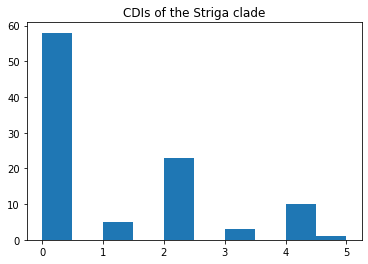

In [74]:
plt.figure()
plt.hist(striga_CDIs)
plt.title('CDIs of the Striga clade')
plt.show()

We can see that the majority of replicates support the location of the Striga clade in the gene tree (CDI=0), but in nearly 40% of the replicates the clade is located differently (CDI>0).  

To analyze how the *Striga* clade's location changes, we'll check what clades it branches with in the bootstrap replicates.  

In [86]:
nbhoods = []
for T in boottrees:
    neighbours = get_multisplit_from_target(T, target_accessions)
    neighbours = [sorted([acc_to_name[acc] for acc in component]) for component in neighbours]
    neighbours.sort()
    # convert a list of lists to a tuple of tuples:
    neighbours = tuple(tuple(n) for n in neighbours)
    nbhoods.append(neighbours)
nbhoods = Counter(nbhoods)

In [88]:
nbhoods

Counter({(('Brachypodium distachyon',
           'Triticum aestivum',
           'Triticum dicoccoides',
           'Triticum dicoccoides'),
          ('Setaria italica',
           'Setaria italica',
           'Setaria italica',
           'Setaria viridis',
           'Setaria viridis',
           'Setaria viridis',
           'Sorghum bicolor',
           'Sorghum bicolor')): 23,
         (('Brachypodium distachyon',
           'Setaria italica',
           'Setaria italica',
           'Setaria italica',
           'Setaria viridis',
           'Setaria viridis',
           'Setaria viridis',
           'Triticum aestivum',
           'Triticum dicoccoides',
           'Triticum dicoccoides'),
          ('Sorghum bicolor', 'Sorghum bicolor')): 10,
         (('Brachypodium distachyon',
           'Sorghum bicolor',
           'Sorghum bicolor',
           'Triticum aestivum',
           'Triticum dicoccoides',
           'Triticum dicoccoides'),
          ('Setaria italica',
      

In 23 replicates, the *Striga* clade branches with the Triticum/Brachypodium clade.  
Such branching does not indicate a horizontal gene transfer.  
We can conclude that although the gene tree shows evidence for a horizontal gene transfer into the *Striga* clade, this event is rather poorly supported.  

**Stability of leaf location**

Now, for each leaf of the gene tree, we will compute its average CDI over the bootstrapped trees.  
This will indicate whether the leaves' location changes over the replicates.  
We'll use a function defined at the bottom of this notebook that returns an ete3 tree with leaves labeled by their average CDIs.  

In [106]:
B = compute_leaf_CDI('Data/BAJ06366.1.genetree',
                     'Data/BAJ06366.1.boottrees')

In [107]:
B.set_outgroup(B.get_midpoint_outgroup())

In [108]:
for l in B:
    l.sci_name = S.search_nodes(name=acc_to_tx[l.name])[0].sci_name

In [109]:
print(B.get_ascii(attributes=['name', 'sci_name', 'CDI']))


         /-XP_021315060.1, Sorghum bicolor, 0.01
      /-|
     |   \-KAG0549370.1, Sorghum bicolor, 0.01
     |
     |      /-XP_004961077.1, Setaria italica, 0.15
     |     |
   /-|     |         /-XP_004956429.1, Setaria italica, 0.11
  |  |   /-|      /-|
  |  |  |  |     |  |   /-XP_034578836.1, Setaria viridis, 0.09
  |  |  |  |   /-|   \-|
  |  |  |  |  |  |      \-TKW32332.1, Setaria viridis, 0.09
  |  |  |   \-|  |
  |   \-|     |   \-TKW32329.1, Setaria viridis, 0.42
  |     |     |
  |     |      \-RCV11063.1, Setaria italica, 0.45
--|     |
  |     |   /-BAJ06366.1, Striga hermonthica, 0.0
  |      \-|
  |         \-BAJ09025.1, Striga gesnerioides, 0.0
  |
  |         /-XP_037439433.1, Triticum dicoccoides, 0.0
  |      /-|
  |   /-|   \-KAF7063565.1, Triticum aestivum, 0.0
  |  |  |
   \-|   \-XP_037439440.1, Triticum dicoccoides, 0.0
     |
      \-XP_003568978.1, Brachypodium distachyon, 0.35


In [103]:
B.show(tree_style=cdi_style)

Low CDI values indicate that the locations of leaves, with some exception of *Setaria viridis*' RCV11063.1 protein and *Brachypodium distachyon*'s XP_003568978.1 protein, are stable.

## Protein AAM94340.1; Vertical inheritance

This is an asparagine synthetase protein, randomly selected from *Striga hermonthica*'s proteome.  
The gene tree of its homologous family supports a typical vertical inheritance of genetic material without horizontal exchange.  
A single gene duplication in *Punica granatum* is the only apparent evolutionary event.  

**Loading the data**

In [111]:
taxid_table = 'Data/AAM94340.1_taxid_table.tsv'
taxid_table = [l.strip().split() for l in open(taxid_table)]

In [112]:
taxids = [t for a,t in taxid_table]
tx_to_acc = {t:a for a,t in taxid_table}
acc_to_tx = {a:t for a,t in taxid_table}

In [125]:
S = Tree('Data/AAM94340.1.speciestree')

In [126]:
print(S.get_ascii(attributes=['sci_name']))


               /-Juglans regia
              |
         /fabids-Trema orientale
        |     |
   /rosids     \-Populus alba
  |     |
  |     |        /-Punica granatum
  |      \Myrtales
--|              \-Eucalyptus grandis
  |
  |        /-Sesamum indicum
  |       |
  |       |--Striga hermonthica
   \Lamiales
          |--Handroanthus impetiginosus
          |
           \-Dorcoceras hygrometricum


In [127]:
S.show(tree_style=species_style)

In [159]:
tx_to_name = {l.name : l.sci_name for l in S}
acc_to_name = {acc: tx_to_name[acc_to_tx[acc]] for acc in acc_to_tx}

In [153]:
G = Tree('Data/AAM94340.1.genetree')
G.set_outgroup(G.get_midpoint_outgroup())
for l in G:
    l.acc = l.name
    l.sci_name = S.search_nodes(name=acc_to_tx[l.name])[0].sci_name

In [154]:
print(G.get_ascii(attributes=['name', 'sci_name']))


            /-XP_031397843.1, Punica granatum
         /-|
      /-|   \-OWM82211.1, Punica granatum
     |  |
     |   \-KCW54483.1, Eucalyptus grandis
   /-|
  |  |      /-XP_018834473.1, Juglans regia
  |  |   /-|
  |   \-|   \-PON86137.1, Trema orientale
--|     |
  |      \-XP_034891943.1, Populus alba
  |
  |   /-KZV49762.1, Dorcoceras hygrometricum
   \-|
     |   /-XP_011097578.1, Sesamum indicum
      \-|
        |   /-AAM94340.1, Striga hermonthica
         \-|
            \-PIN18930.1, Handroanthus impetiginosus


**Checking for HGT**

In [35]:
target_taxids = {'68872'}

In [131]:
gs = get_multisplit_from_target(G, target_taxids)
ss = get_multisplit_from_target(S, target_taxids)
CDI = multisplit_distance(gs, ss)
print('CDI of the Striga clade between the gene and the species trees is equal to', CDI)

CDI of the Striga clade between the gene and the species trees is equal to 0.0


No displacement of the Striga clade between the gene and the species tree indicates no evidence for HGT into this species, as long as the gene tree is unrooted.  

**Gene tree stability analysis**

In [132]:
B = compute_leaf_CDI('Data/AAM94340.1.genetree',
                     'Data/AAM94340.1.boottrees')

In [136]:
for l in B:
    l.accession = l.name
    l.sci_name = S.search_nodes(name=acc_to_tx[l.name])[0].sci_name

In [137]:
print(B.get_ascii(attributes=['name', 'sci_name', 'CDI']))


            /-XP_031397843.1, Punica granatum, 0.0
         /-|
      /-|   \-OWM82211.1, Punica granatum, 0.0
     |  |
     |   \-KCW54483.1, Eucalyptus grandis, 0.02
   /-|
  |  |      /-XP_018834473.1, Juglans regia, 0.39
  |  |   /-|
  |   \-|   \-PON86137.1, Trema orientale, 0.39
--|     |
  |      \-XP_034891943.1, Populus alba, 1.04
  |
  |   /-KZV49762.1, Dorcoceras hygrometricum, 0.75
   \-|
     |   /-XP_011097578.1, Sesamum indicum, 0.77
      \-|
        |   /-AAM94340.1, Striga hermonthica, 0.07
         \-|
            \-PIN18930.1, Handroanthus impetiginosus, 0.07


In [140]:
B.show(tree_style=cdi_style)

Large values of leaf CDIs indicate that the topology of this tree is unstable.  
This is in accordance with low bootstrap values of branches.  
However, CDI allows to easily identify the unstable leaves (and, if needed, clades).   
In this case, it is the XP_034891943.1 protein of *Populus alba*.  

Let's inspect this leaf in more detail. First, load the bootstrapped trees:

In [150]:
with open('Data/AAM94340.1.boottrees') as h:
    boottrees = [Tree(l) for l in h]
for T in boottrees:
    T.set_outgroup(T.get_midpoint_outgroup())
print(len(boottrees), 'bootstrapped trees loaded')

100 bootstrapped trees loaded


First, compute the CDIs and plot them on a histogram:

In [166]:
target_accessions = {'XP_034891943.1'}

In [167]:
populus_CDIs = []
for T in boottrees:
    gs = get_multisplit_from_target(G, target_accessions)
    ts = get_multisplit_from_target(T, target_accessions)
    CDI = multisplit_distance(gs, ts) 
    populus_CDIs.append(CDI)

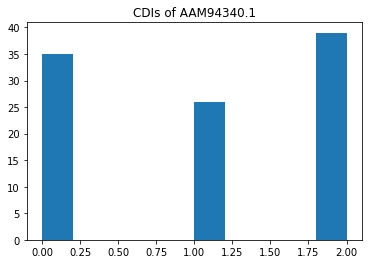

In [168]:
plt.figure()
plt.hist(populus_CDIs)
plt.title('CDIs of AAM94340.1')
plt.show()

We can see a distribution of a different type than what we've seen for the *Striga* clade in the previous analysis.  
Now, in the majority of replicates, the location of AAM94340.1 is different than in the gene tree.   
Most commonly we encounter shifts with CDI equal 2.  
The same location is encountered in only 35 out of 100 replicates.  

Let's inspect the neighbourhoods of this leaf to see how it changes location between bootstrap replicates.  

In [180]:
nbhoods = []
for T in boottrees:
    neighbours = get_multisplit_from_target(T, target_accessions)
    neighbours = [sorted([acc_to_name[acc] for acc in component]) for component in neighbours]
    neighbours.sort()
    neighbours = tuple(tuple(component) for component in neighbours)
    nbhoods.append(neighbours)
nbhood_counter = Counter(nbhoods)

In [181]:
nbhood_counter

Counter({(('Dorcoceras hygrometricum',
           'Eucalyptus grandis',
           'Handroanthus impetiginosus',
           'Punica granatum',
           'Punica granatum',
           'Sesamum indicum',
           'Striga hermonthica'),
          ('Juglans regia', 'Trema orientale')): 35,
         (('Dorcoceras hygrometricum',
           'Handroanthus impetiginosus',
           'Juglans regia',
           'Sesamum indicum',
           'Striga hermonthica',
           'Trema orientale'),
          ('Eucalyptus grandis', 'Punica granatum', 'Punica granatum')): 17,
         (('Dorcoceras hygrometricum',
           'Eucalyptus grandis',
           'Handroanthus impetiginosus',
           'Juglans regia',
           'Punica granatum',
           'Punica granatum',
           'Sesamum indicum',
           'Striga hermonthica'),
          ('Trema orientale',)): 26,
         (('Dorcoceras hygrometricum',
           'Handroanthus impetiginosus',
           'Sesamum indicum',
           'Striga 

Map the neighbourhoods to their CDI values:

In [183]:
nbhoods_and_cdis = set(zip(nbhoods, populus_CDIs))

In [187]:
for i, x in enumerate(nbhoods_and_cdis):
    print('Neighbourhood %i:' % i)
    print('Sister 1:', ', '.join(x[0][0]))
    print('Sister 2:', ', '.join(x[0][1]))
    print('CDI = ', x[1])
    print('Occured', nbhood_counter[x[0]], 'times')
    print()

Neighbourhood 0:
Sister 1: Dorcoceras hygrometricum, Handroanthus impetiginosus, Sesamum indicum, Striga hermonthica
Sister 2: Eucalyptus grandis, Juglans regia, Punica granatum, Punica granatum, Trema orientale
CDI =  2.0
Occured 21 times

Neighbourhood 1:
Sister 1: Dorcoceras hygrometricum, Handroanthus impetiginosus, Juglans regia, Punica granatum, Punica granatum, Sesamum indicum, Striga hermonthica, Trema orientale
Sister 2: Eucalyptus grandis
CDI =  2.0
Occured 1 times

Neighbourhood 2:
Sister 1: Dorcoceras hygrometricum, Handroanthus impetiginosus, Juglans regia, Sesamum indicum, Striga hermonthica, Trema orientale
Sister 2: Eucalyptus grandis, Punica granatum, Punica granatum
CDI =  2.0
Occured 17 times

Neighbourhood 3:
Sister 1: Dorcoceras hygrometricum, Eucalyptus grandis, Handroanthus impetiginosus, Juglans regia, Punica granatum, Punica granatum, Sesamum indicum, Striga hermonthica
Sister 2: Trema orientale
CDI =  1.0
Occured 26 times

Neighbourhood 4:
Sister 1: Dorcoceras

We can see that we have four neighbourhoods for XP_034891943.1 with roughly similar supports (between 17 and 35 replicates).   
The neighbourhood from the gene tree, supported by 35 replicates, is the most commonly encountered one.  
We have two frequent neighbourhoods with CDI=2. This is why this value is the most common one in the histogram that we've seen above.    

In contrast, *Striga hermontica* has the same neighbourhood in 93 out of 100 replicates.

## Module imports & function definitions 
Run this section before analysis.

In [67]:
from ete3 import Tree, TreeStyle, NodeStyle, AttrFace, faces, TextFace
from warnings import warn
from collections import Counter
import numpy as np
from matplotlib import pyplot as plt

In [34]:
def LCA(T, leaf_set):
    # Since we use leaf pointers not leaf labels in this implementation, 
    # we can use the fact that leaves are unique
    # and traverse the tree in postorder, storing how many leaves we're lacking to 
    # be the common ancestor.
    n = len(leaf_set)
    if n == 1:
        return list(leaf_set)[0]
    assert leaf_set.issubset(set(T)), 'Target leaf set is not a subset of leaves of T!'
    number_below = {g: 0 for g in T.traverse()}
    prev_node = T
    for g in T.traverse('postorder'):
        if g.is_leaf():
            if g in leaf_set:
                number_below[g] = 1
        else:
            nb = sum(number_below[c] for c in g.children) 
            if nb == n:
                return g
            else:
                number_below[g] = nb   
    if nb == n:
        return T
    else:
        raise RuntimeError('Unable to find LCA!')

In [35]:
def get_separating_branch(T, target_names):
    """
    If target_names are strictly monophyletic in T, return the end node of the branch 
    that separates them from the other leaves. 
    Otherwise, return None.
    
    Parameters
    ----------
    T: ete3 Tree object
    target_names: a set of species names. 
        It is assumed that leaves of T are labelled with species names, without gene identifiers. 
    """
    if len(T.children) == 3:
        warn('The tree appears to be unrooted!')
    target_leaves = {l for l in T if l.name in target_names}
    other_leaves = {l for l in T if l.name not in target_names}
    if not target_leaves or not other_leaves:
        print('No 1')
        return None
    target_names = set(target_names)
    other_names = {l.name for l in other_leaves}
    
    target_lca = LCA(T, target_leaves)
    other_lca = LCA(T, other_leaves)
    names_under_target_lca = {l.name for l in target_lca}
    names_under_other_lca = {l.name for l in other_lca}
    # print(target_names, other_names, names_under_target_lca, names_under_other_lca)
    if target_names == names_under_target_lca:
        return target_lca
    elif other_names == names_under_other_lca:
        return other_lca
    else:
        print('No 2')
        return None

In [36]:
def get_multisplit_from_target(T, target_names, verbose=False):
    """
    Returns a list of clades going outwards from the LCA of target_names. 
    That is, a forest obtained by removing the clade of target_names together with its parent node.
    Effectively, this is an implementation of get_split_from_target for non-binary trees.
    Assumes that T is rooted. Applying this function to an unrooted tree will give improper results.
    The position of the root does not matter, so the tree may be rooted arbitrarily.
    
    Parameters
    ---------
    T: ete3 Tree object
        The tree to process.
        It is assumed that leaves of T are named using species names.
    target_names: iterable
        The set of species names defining the reference clade.
        The target names need to form a strictly monophyletic clade in T. 
        Otherwise, an error is raised.
    
    Returns: list
        A list of lists. Each component contains leaf labels of T corresponding
        to a clade going outwards from the target clade.
    
    """
    # assert check_strict_monophyly(T, target_names), 'The target leaves are not monophyletic!'
    if len(T.children) == 3:
        warn('The tree appears to be unrooted!')
    target_leaves = {l for l in T if l.name in target_names}
    non_target_leaves = {l for l in T if l.name not in target_names}
    assert target_leaves, 'No target found in tree!'
    assert len(non_target_leaves)>1, 'Not enough non-target species in tree!'
    # print(target_leaves)
    lca = LCA(T, target_leaves)
    if verbose:
        print(lca)
    ### We need to handle three cases here: target LCA being the root, one of its children, or another node.
    # Case 1:
    if lca == T:
        # This is the most complex case - need to find LCA of non-target species and return its children
        if verbose:
            print('Case 1')
        lca2 = LCA(T, non_target_leaves)
        split = [[l.name for l in c] for c in lca2.children]
    elif lca in T.children and len(T.children) > 2:
        if verbose:
            print('case2')
        split = [[l.name for l in c] for c in T.children if c != lca]
    elif lca in T.children and len(T.children) == 2:
        if verbose:
            print('case3')
        if lca == T.children[0]:
            split = [[l.name for l in c] for c in T.children[1].children]
        else: 
            split = [[l.name for l in c] for c in T.children[0].children]
    else:
        if verbose:
            print('case4')
        split = [[l.name for l in c] for c in lca.get_sisters()]  # sisters of lca
        split.append([l.name for l in T if l not in lca.up])  # remaining leaves
    return split

In [37]:
def multisplit_distance(gene_split, species_split, verbose=False):
    """
    Computes the multisplit distance, defined as the minimal absolute difference 
    of the proportion of each label in the left out-going clade in both trees 
    over all refinements of species_split.
    
    Parameters
    ----------
    split1, split2: iterables
        Compared splits. Each component contains a list of leaf labels.
        The labels in split2 need to be unique, but in split1 they do not. 
        Labels are matched between splits by their name.
        All labels from gene_split and species_split need to correspond to each other exactly.
    """
    assert len(gene_split) == 2, 'gene_split needs to have length 2'
    gene_split_labels = set(l for s in gene_split for l in s)
    species_split_labels = set(l for s in species_split for l in s)
    if not gene_split_labels == species_split_labels:
        raise ValueError('the splits contain different labels:\n%s\n%s' % (str(gene_split_labels), str(species_split_labels)))
    
    # check if labels in split2 are unique:
    s2 = Counter()
    for cmp in species_split:
        for spc in cmp:
            s2[spc] += 1
    assert set(s2.values()) == {1}, 'non-unique labels in split2!'
    
    # compute label scores for gene_split
    # i.e. the proportion of occurence in the reference split
    left_count = Counter(gene_split[0])  
    total_count = left_count + Counter(gene_split[1])
    gene_label_score = {label: left_count[label]/total_count[label] for label in gene_split_labels}
    if verbose:
        print(gene_label_score)

    distance = 0.
    for cmp in species_split:
        if verbose:
            print(cmp)
        s1 = sum(gene_label_score[label] for label in cmp)
        s2 = len(cmp) - s1
        distance += min(s1, s2)
        if verbose:
            print('current choices:', s1, s2)
            print('current distance:', distance)
    assert distance >= 0, 'negative distance - bug!'
    return distance

In [38]:
def compute_leaf_CDI(tree_file, bootstrap_file):
    """
    Returns an ete3 Tree object constructed from tree_file 
    with leaves labelled with average branch displacement index
    computed from bootstrap replicates from bootstrap_file.
    """
    T = Tree(tree_file)
    T.set_outgroup(T.get_midpoint_outgroup())
    for l in T:
        l.CDI = 0.
    B_file = open(bootstrap_file)
    N = 0
    for B in B_file:
        B = Tree(B)
        N += 1
        B.set_outgroup(B.get_midpoint_outgroup())
        for l1 in T:
            # l2 = B&l1.name
            split1 = get_multisplit_from_target(T, {l1.name})
            split2 = get_multisplit_from_target(B, {l1.name})
            d = multisplit_distance(split1, split2)
            l1.CDI += d
    for l in T:
        l.CDI /= N
    return T

In [39]:
def species_layout(node):
    style = NodeStyle()
    style["fgcolor"] = "#0f0f0f"
    style["size"] = 0
    style["vt_line_color"] = "black"
    style["hz_line_color"] = "black"
    style["vt_line_width"] = 3
    style["hz_line_width"] = 3
    style["vt_line_type"] = 0 # 0 solid, 1 dashed, 2 dotted
    style["hz_line_type"] = 0
    node.set_style(style)
    if node.is_leaf():
        faces.add_face_to_node(AttrFace('sci_name', text_prefix=' ', fstyle='italic'), node, column=0, position='branch-right')

In [100]:
def gene_layout(node):
    style = NodeStyle()
    style["fgcolor"] = "#0f0f0f"
    style["size"] = 0
    style["vt_line_color"] = "black"
    style["hz_line_color"] = "black"
    style["vt_line_width"] = 3
    style["hz_line_width"] = 3
    style["vt_line_type"] = 0 # 0 solid, 1 dashed, 2 dotted
    style["hz_line_type"] = 0
    node.set_style(style)
    if node.is_leaf():
        faces.add_face_to_node(AttrFace('accession', text_prefix=' ', text_suffix = '; '), node, column=0, position='branch-right')
        faces.add_face_to_node(AttrFace('sci_name', text_suffix = '; ', fstyle='italic'), node, column=1, position='branch-right')
        # faces.add_face_to_node(AttrFace('CDI', text_prefix = 'CDI=', text_suffix=' ', fgcolor='Navy'), node, column=2, position='branch-right')

        # faces.add_face_to_node(TextFace('  ', fsize=8), node, column=1, position='branch-right')
    else:
        faces.add_face_to_node(AttrFace('support', text_prefix=' ', text_suffix = '  ', fgcolor='red', fsize=8, formatter='%i'), node, column=0, position='branch-top')

In [99]:
def cdi_layout(node):
    style = NodeStyle()
    style["fgcolor"] = "#0f0f0f"
    style["size"] = 0
    style["vt_line_color"] = "black"
    style["hz_line_color"] = "black"
    style["vt_line_width"] = 3
    style["hz_line_width"] = 3
    style["vt_line_type"] = 0 # 0 solid, 1 dashed, 2 dotted
    style["hz_line_type"] = 0
    node.set_style(style)
    if node.is_leaf():
        faces.add_face_to_node(AttrFace('sci_name', text_prefix=' ', text_suffix = '', fstyle='italic'), node, column=0, position='branch-right')
        faces.add_face_to_node(AttrFace('accession', text_prefix=' ', text_suffix = '; '), node, column=1, position='branch-right')
        
        faces.add_face_to_node(AttrFace('CDI', text_prefix = 'AvCDI = ', text_suffix=' ', fgcolor='Navy'), node, column=2, position='branch-right')

        # faces.add_face_to_node(TextFace('  ', fsize=8), node, column=1, position='branch-right')
    elif not node.is_root():
        faces.add_face_to_node(AttrFace('support', text_prefix=' ', text_suffix = '  ', fgcolor='red', fsize=8, formatter='%i'), node, column=0, position='branch-top')

In [42]:
species_style = TreeStyle()
species_style.show_leaf_name = False
species_style.layout_fn = species_layout
species_style.show_scale = False

In [43]:
gene_style = TreeStyle()
gene_style.show_leaf_name = False
gene_style.layout_fn = gene_layout
gene_style.show_scale = False
gene_style.show_branch_support = False
gene_style.scale = 1200

In [102]:
cdi_style = TreeStyle()
cdi_style.show_leaf_name = False
cdi_style.layout_fn = cdi_layout
cdi_style.show_scale = False
cdi_style.show_branch_support = False
cdi_style.scale = 1200